In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random #generating negative random numbers

from mpl_toolkits.mplot3d import Axes3D # for 3D visualization


In [2]:
Ldend = 180
soma = np.zeros(3)
soma= np.array([-150,-300,0])

DEBUG=False

def debug_print(*s):
    if DEBUG:
        print(*s)
    else:
        pass

def make_random_dend_ends():
    angle0 = np.random.rand()*np.pi/2
    debug_print("Starting Point",angle0) #random starting point
    # first 3 angles between dends
    angles3 = np.ones(3)*np.pi/2
    angles = np.cumsum(angles3) 
    angles = np.hstack([0, angles]) + angle0 

    #adding more variability for each point independent from the others
    r=np.random.uniform(-0.5, 0.5,4)
    angles=angles+r
    debug_print("Single Point Variation=", r)

    #produce x and y coordinates
    return np.array([[Ldend*np.cos(a), Ldend*np.sin(a)] for a in angles]) # cos=x; sin=y
    
point1_xz = make_random_dend_ends()               
print(point1_xz)

print(soma)
point1_xz = point1_xz + soma[:2]               

print(point1_xz)




[[  48.46413285  173.35289968]
 [-100.24353546  149.50328959]
 [-125.20179481 -129.32327933]
 [ 158.59075166  -85.14090374]]
[-150 -300    0]
[[-101.53586715 -126.64710032]
 [-250.24353546 -150.49671041]
 [-275.20179481 -429.32327933]
 [   8.59075166 -385.14090374]]


In [3]:
#circle
theta = np.linspace( 0 , 2 * np.pi , 170 )  
radius = Ldend #ToDO automate: point -soma?
Ca = radius * np.cos( theta )+soma[0]
Cb = radius * np.sin( theta )+soma[1]

In [4]:
# upper and lower borders (y= mx+n)
xlay=np.linspace(-500,150,150)
upperLimit=-250 #MLI layer border
lowerLimit=-75 #MLI layer border
up=0*xlay+upperLimit
down=0*xlay+lowerLimit

In [5]:
##Check if upper layer limit collides with dendrite radius around soma
#calculate distance between layer and soma
d=abs(soma[1]-upperLimit)
print(d)
if d < radius:
    print("Dendrites might interfere with layer limit")
elif d <= radius:
    print("Dendrites might reach layer limit")
else:
    print("There is enough space for dendrites")



50
Dendrites might interfere with layer limit


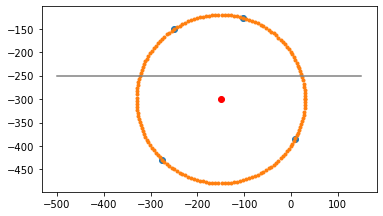

In [6]:
#plot
figure, axes= plt.subplots(1)

axes.plot(point1_xz[:,0], point1_xz[:,1], 'o')
axes.plot(soma[0],soma[1], 'or')

axes.plot(Ca,Cb, ".")
axes.plot(xlay,up, "grey")
#axes.plot(xlay,down, "grey")
axes.set_aspect(1)

In [7]:
#check which dendrite is outside of the layer and correct its position
def fix_dend_ends_upper(point1_xz, soma, upperLimit, push_down=100):
    
    d=abs(soma[1]-upperLimit)
    
    point1_xz_new = np.zeros_like(point1_xz)
    for i in range(point1_xz.shape[0]):
        x, y=point1_xz[i];
        
        #print(point1_xz[i]);
        if y>soma[1]+d:
            debug_print("Dendrite",i, "is outside the layer:", point1_xz[i]);
            if point1_xz[i,0]< soma[0]:       # make sure each dendrite goes to one one side
                y=soma[1]+d- np.random.uniform(0, push_down); #soma y coord. plus the distance to layer+ variability 
                point1_xz_new[i,1]=y
                phi=np.arcsin((y-soma[1])/radius) # calculate phi for new x
                x1=radius*np.cos(phi)+soma[0]     # new x coord. on layer
                point1_xz_new[i,0]=soma[0]-(x1-soma[0]) 
            else:
                y=soma[1]+d- np.random.uniform(0, push_down); #soma y coord. plus the distance to layer
                phi=np.arcsin((y-soma[1])/radius) # calculate phi for new x
                x1=radius*np.cos(phi)+soma[0]     # new x coord. on layer
                point1_xz_new[i,:]=[x1, y]
            debug_print("New Coordinates", point1_xz[i])
        else:
            debug_print("Dendrite",i, "is inside the layer ")
            point1_xz_new[i,:]= [x, y]

    return point1_xz_new


point1_xz_new = fix_dend_ends_upper(point1_xz, soma, -250)

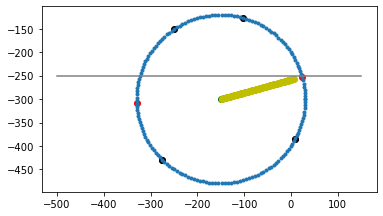

In [18]:
#plot
figure, axes= plt.subplots(1)

axes.plot(point1_xz_new[:,0], point1_xz_new[:,1], 'or')
axes.plot(point1_xz[:,0], point1_xz[:,1], 'ok')
axes.plot(soma[0],soma[1], 'og')
axes.plot(xDend[:],yDend[:],'oy')
axes.plot(Ca,Cb, ".")
axes.plot(xlay,up, "grey")
#axes.plot(xlay,down, "grey")
axes.set_aspect(1)

Add points between Soma and EndPoint

In [10]:
#calculate x values for points between soma and endpoint
#xDendAll=np.empty((0,0), dtype=object)
xDendAll = np.zeros(shape=(0))
for i in range(point1_xz_new.shape[0]):
    nPoint= 90
    xLen=abs(soma[0]-point1_xz_new[i,0]) # length of dendrite on x axis
    xComp= xLen/nPoint # distance of compartments on x axis
    xDend=(np.cumsum(np.ones(nPoint-1)*xComp))+ soma[0]
    xDendAll = np.append(xDendAll, xDend, axis=0)


In [11]:
#calculating slope
m=(soma[1]-point1_xz_new[0,1])/(soma[0]-point1_xz_new[0,0])

In [12]:
#function
for i in range(point1_xz_new.shape[0]):
    yDend=np.array(m*xDend-m*soma[0]+soma[1])


In [13]:
point1_xz_new

array([[  23.49957902, -252.06362466],
       [-329.8171574 , -308.11109756],
       [-275.20179481, -429.32327933],
       [   8.59075166, -385.14090374]])

In [17]:
len(xDendAll)

356

ADD MORE SOMA

In [185]:
soma = np.zeros((60,3))
somas = np.array([np.random.uniform(-600,600,3) for i in soma]) # cos=x; sin=y
somas[:,0] = np.random.uniform(-600, 600, size=60)
somas[:,1] = np.random.uniform(20, 180, size=60)


print("We generated", len(somas), "somas.")

We generated 60 somas.


In [186]:
max(somas[:,1])

176.53671425300183

In [187]:
# upper and lower borders (y= mx+n)
xlay=np.linspace(-600,600,600)
upperLimit=max(somas[:,1])+20 #MLI layer border
lowerLimit=min(somas[:,1]-20) #MLI layer border

#upperLimit= 200 #MLI layer border
up=0*xlay+upperLimit
down=0*xlay+lowerLimit

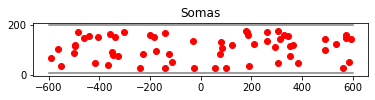

In [188]:
figure, axes= plt.subplots(1)

#axes.plot(point1_xz[:,0], point1_xz[:,1], 'o')
#axes.plot(Ca,Cb, ".")
axes.plot(somas[:,0],somas[:,1] ,'or')
axes.plot(xlay,up, "grey")
axes.plot(xlay,down, "grey")


axes.set_aspect(1)
plt.title("Somas");

In [189]:
somas.shape

(60, 3)

In [190]:
##generate endpoints around respective somas
EpointDendx=np.empty((0,2), dtype=object) #empty array for dendrites
EpointDend=np.empty((0,2), dtype=object) #empty array for dendrites
for s in range(somas.shape[0]):
    
    soma = somas[s,:2]
    point1_xz = make_random_dend_ends() + soma
    point1_xz_new = fix_dend_ends_upper(point1_xz, soma, upperLimit)
    point1_xz_new = -fix_dend_ends_upper(-point1_xz_new, -soma, lowerLimit)


    EpointDendx = np.append(EpointDendx, point1_xz, axis=0)
    EpointDend = np.append(EpointDend, point1_xz_new, axis=0)
    

In [314]:
EpointDendx.shape

(240, 2)

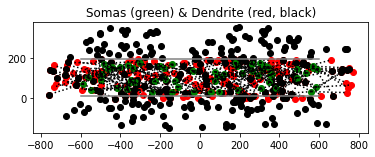

In [191]:
def plot_one_skeleton(soma, pointDend, axes):
    for i in range(pointDend.shape[0]):
        dend_point = pointDend[i, :]
        axes.plot([soma[0], dend_point[0]], [soma[1], dend_point[1]], ':k')

def plot_skeletons(somas, point_dends, axes):
    for s in range(somas.shape[0]):
        soma = somas[s,:2]
        point_dends_1 = point_dends[(s*4):((s+1)*4),:]
        plot_one_skeleton(soma, point_dends_1, axes)
        
figure, axes= plt.subplots(1)

axes.plot(EpointDend[:,0], EpointDend[:,1], 'or')
axes.plot(EpointDendx[:,0], EpointDendx[:,1], 'ok')
axes.plot(somas[:,0],somas[:,1] ,'og')
plot_skeletons(somas, EpointDend, axes)
    
axes.plot(xlay,up, "grey")
axes.plot(xlay,down, "grey")


axes.set_aspect(1)
plt.title("Somas (green) & Dendrite (red, black)");

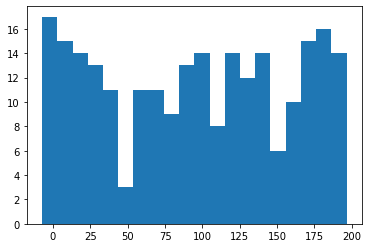

In [195]:
plt.hist(EpointDend[:,1],20);



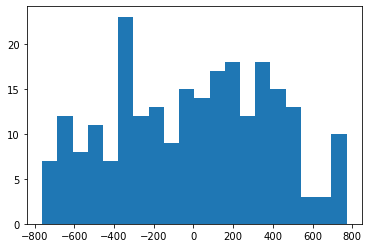

In [196]:
plt.hist(EpointDend[:,0],20);



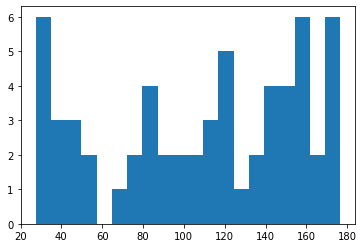

In [197]:
plt.hist(somas[:,1],20);



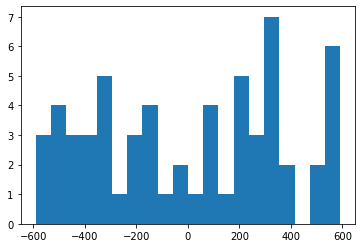

In [198]:
plt.hist(somas[:,0],20);



WHAT ABOUT 3D?

In [20]:
Ldend = 150




In [151]:
for i in test:
    print(i)
    test

[0 1 2]
[2 3 4]


In [48]:
import matplotlib.colors as mcolors

colors = [(1,0,0,c) for c in np.linspace(0,1,100)]
cmapred = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=5)
colors = [(0,0,1,c) for c in np.linspace(0,1,100)]



cmapblue = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=5)

In [11]:
#%matplotlib notebook

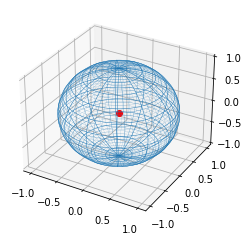

In [63]:
#plotting sphere

phi = np.linspace(0, np.pi, 100)
theta = np.linspace(0, 2*np.pi, 100)
phi, theta = np.meshgrid(phi, theta)

x = np.sin(phi) * np.cos(theta)
y = np.sin(phi) * np.sin(theta)
z = np.cos(phi)


fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, r)#,cmap=cmapblue)
ax.plot(0,0,0,'or')


plt.show()